In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
"""
Load the data set we will be working with
"""

data_dir = 'Datasets'
dataset_name = 'BioTIME Study 373'

df = pd.read_csv(f'{data_dir}/study_373/top_5_373.csv')
df.drop(columns = 'DATE', inplace = True)
df = (df - df.mean()) / df.std()
display(df)

,46670,46982,46504,46571,46888
0,-1.255714,-0.845560,-0.924228,-1.008546,-0.302961
1,-1.255714,-0.656750,-0.924228,-1.008546,-0.302961
2,-1.047312,-0.090321,-0.487138,-1.008546,-0.764449
3,-1.047312,-1.034370,-0.924228,-1.008546,0.158526
4,-1.047312,-0.467941,-0.924228,-1.008546,-0.302961
...,...,...,...,...,...
388,0.619903,-0.090321,-0.924228,-1.008546,-0.302961
389,0.203099,-0.090321,-0.924228,-1.008546,0.158526
390,-0.838910,-1.034370,-0.924228,-1.008546,-0.302961
391,-1.047312,0.098489,-0.924228,-1.008546,-0.302961


In [3]:
"""
Set the parameters for the linear regression here
"""

# We will look at the last three values for each species and try to predict the next value using linear regression
lag = 2

expected = df.iloc[lag:, :]
display(expected)

,46670,46982,46504,46571,46888
2,-1.047312,-0.090321,-0.487138,-1.008546,-0.764449
3,-1.047312,-1.034370,-0.924228,-1.008546,0.158526
4,-1.047312,-0.467941,-0.924228,-1.008546,-0.302961
5,-1.047312,-0.467941,-0.924228,-1.008546,0.158526
6,-0.422106,-0.090321,-0.487138,-0.525771,-0.302961
...,...,...,...,...,...
388,0.619903,-0.090321,-0.924228,-1.008546,-0.302961
389,0.203099,-0.090321,-0.924228,-1.008546,0.158526
390,-0.838910,-1.034370,-0.924228,-1.008546,-0.302961
391,-1.047312,0.098489,-0.924228,-1.008546,-0.302961


In [4]:
def predict(index, species, df, lag):
    data = df.loc[index - lag : index - 1, species]

    y = data.to_numpy()
    x = np.arange(start = index - lag, stop = index)
    
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    
    return m * index + c


In [5]:
predicted = np.array([[predict(index, species, df, lag) for index in range(lag, len(df))] for species in df.columns])

In [6]:
error = pd.DataFrame()

for i, column in enumerate(df.columns):
    error[column] = pd.Series((expected.to_numpy().T - predicted)[i])

display(error)

,46670,46982,46504,46571,46888
0,2.084018e-01,0.377619,4.370896e-01,-2.220446e-16,-0.461488
1,-2.084018e-01,-1.510478,-8.741793e-01,-2.220446e-16,1.384464
2,2.220446e-16,1.510478,4.370896e-01,2.220446e-16,-1.384464
3,-2.220446e-16,-0.566429,1.110223e-16,-4.440892e-16,0.922976
4,6.252054e-01,0.377619,4.370896e-01,4.827754e-01,-0.922976
...,...,...,...,...,...
386,-1.250411e+00,-1.132858,-3.496717e+00,-1.931102e+00,-1.384464
387,-2.006728e-14,0.566429,1.748359e+00,9.655508e-01,0.922976
388,-6.252054e-01,-0.944049,0.000000e+00,-2.220446e-16,-0.922976
389,8.336072e-01,2.076907,-3.330669e-16,-4.440892e-16,0.461488


In [7]:
import torch
from torcheval.metrics.functional import r2_score

import statistics

np_error = error.to_numpy()
mse_loss = np.mean(np_error * np_error)
r2_loss = statistics.fmean([r2_score(torch.tensor(predicted[i]), torch.tensor(expected[o].tolist())) for i, o in enumerate(expected.columns)])
l1_loss = np.mean(np.abs(np_error))

print(f'MSE: {mse_loss:.4f}')
print(f'R2 Score: {r2_loss:.4f}')
print(f'MAE: {l1_loss:.4f}')

MSE: 3.6759
R2 Score: -2.6817
MAE: 1.3285


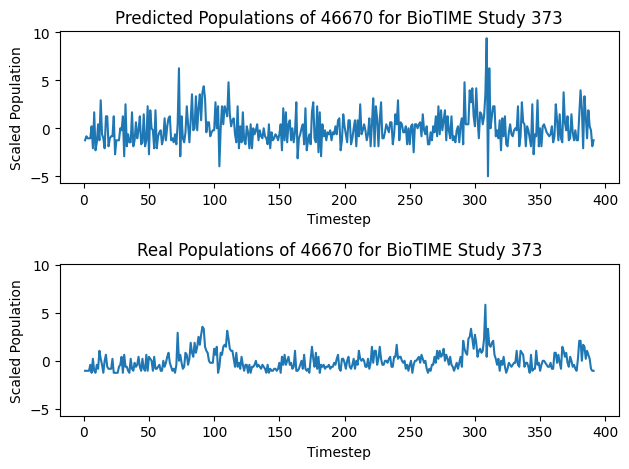

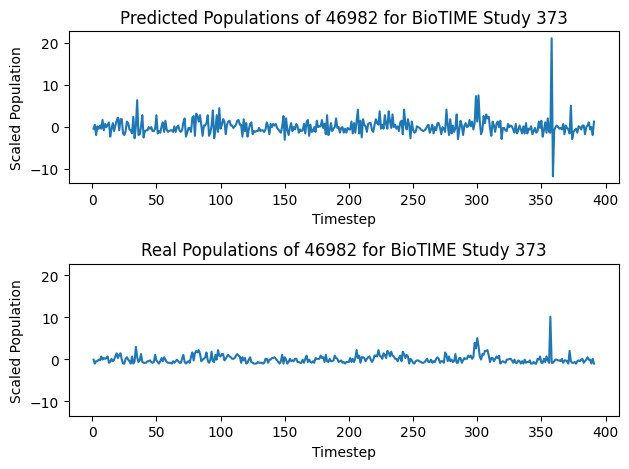

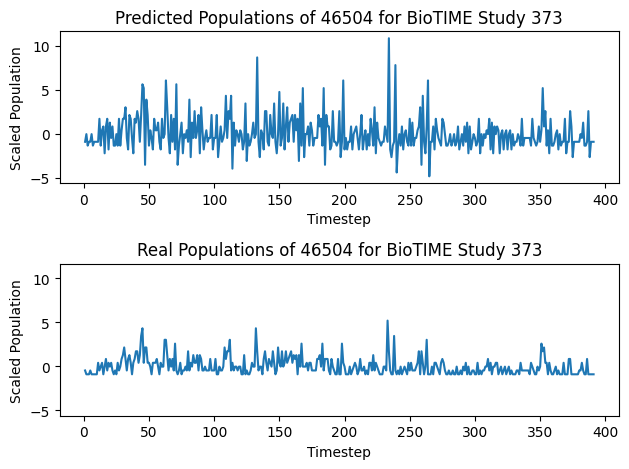

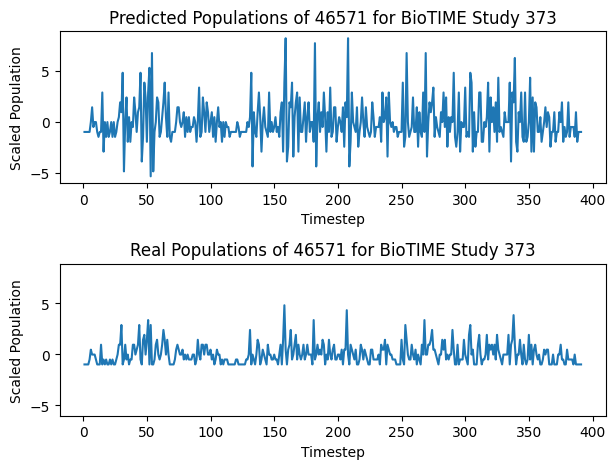

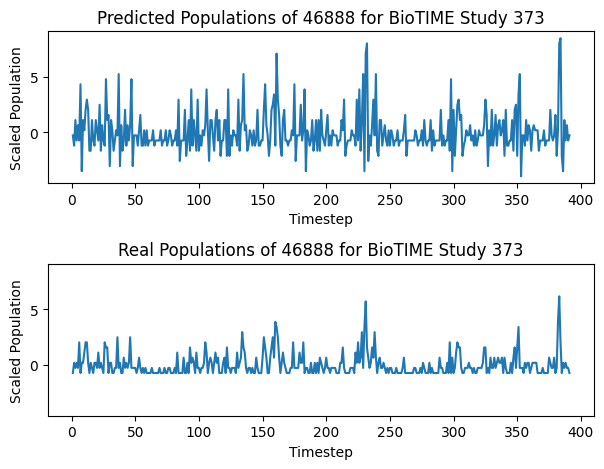

In [8]:
for i, s in enumerate(expected.columns):
    fig, (p, r) = plt.subplots(2, sharey = True)
    
    p.plot(range(1, len(predicted[i]) + 1), predicted[i])
    p.title.set_text(f'Predicted Populations of {s} for {dataset_name}')
    p.set_xlabel('Timestep')
    p.set_ylabel('Scaled Population')
    r.plot(range(1, len(predicted[i]) + 1), expected[s].tolist())
    r.title.set_text(f'Real Populations of {s} for {dataset_name}')
    r.set_xlabel('Timestep')
    r.set_ylabel('Scaled Population')
    plt.tight_layout()
    plt.show()